In [2]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [3]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [4]:
import matplotlib.pyplot as plt

# Dataset

In [5]:
#choose standard dataset here - e.g. MNIST, Fashion MNIST, Kuzushiji MNIST
dataset = "fashion_mnist"

In [6]:
#load the dataset
n_batch = 128
train_ds, x_train, y_train = load_dataset(dataset, split="train", is_training=True, batch_size=n_batch)
train = iter(train_ds)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-30 14:28:52.449887: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
n_train = x_train.shape[0]
x_train.shape

(60000, 28, 28, 1)

# Model

In [8]:
def in_layer(x, 
           vsa_dimension: int = 1024,
           spiking: bool = False,
           **kwargs):
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    return x

In [48]:
def mlp(x, 
           n_layers: int = 1,
           n_hidden: int = 128,
           vsa_dimension: int = 1024,
           spiking: bool = False,
           repeats: int = 3,
           is_training: bool = False,
           **kwargs):
    """
    Simple MLP model with scalable number of hidden layers
    """
    
    x = scale_mnist(x)
    #project into VSA
    x = ProjectAll(vsa_dimension)(x)
    x = layer_norm(x)

    if spiking:
        x = phase_to_train(x, repeats=repeats)
    
    outputs = []
    for i in range(n_layers):
        x = conv_1d(n_hidden)(x, spiking=spiking, **kwargs)
        outputs.append(x)

    x = conv_1d(10)(x,  spiking=spiking, **kwargs)
    outputs.append(x)

    #only return the single output if training
    if is_training:
        return x

    if spiking: 
        p = train_to_phase(x)
        best_cycle = dphase_postmax(p)
        p = p[:,:,best_cycle]

        return p, outputs
    else:

        return x, outputs

In [49]:
#declare the model as a transformation
model = hk.transform(mlp)

In [37]:
#declare the model as a transformation
model2 = hk.transform(mlp2)

In [50]:
#instantiate the first PRNG key
key = jrnd.PRNGKey(42)

In [51]:
#split the key and use it to create the model's initial parameters
key, subkey = jrnd.split(key)
params = model.init(subkey, x_train[0:10,...])

In [40]:

params2 = model2.init(subkey, x_train[0:10,...], n_layers = 2)

In [52]:
#create an instance of the RMSprop optimizer
opt = optax.rmsprop(0.001)

In [42]:
#get a sample batch from the train set
b = next(train)
x = b['image']
y = b['label']

b x y c ->  (128, 28, 28, 1)


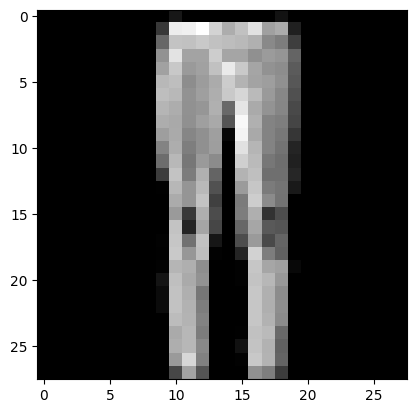

In [43]:
print("b x y c -> ", x.shape)
plt.imshow(x[0,...], cmap="gray");

Text(0, 0.5, 'Density')

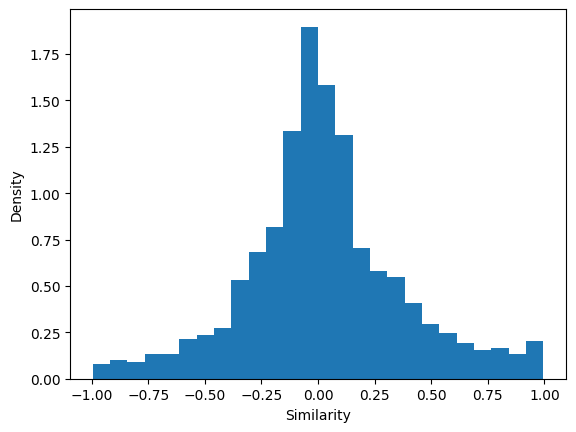

In [53]:
#sample the initial similarities the model produces between an 
# image and the class codebook. 

pred = model.apply(params, key, x)[0]

plt.hist(np.array(pred.ravel()), bins=26, density=True)
plt.xlabel("Similarity")
plt.ylabel("Density")

Text(0.5, 1.0, 'Pre-Train Similarity')

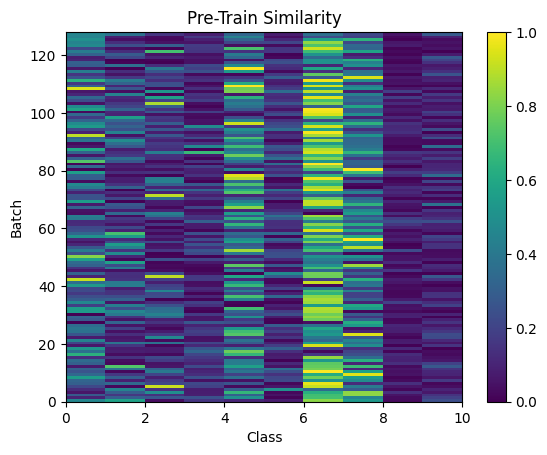

In [55]:
#Visualize the similarity each sample produces to the class codebook
plt.pcolor(jnp.abs(pred), vmax=1.0, vmin=0.0)
plt.xlabel("Class")
plt.ylabel("Batch")
plt.colorbar()
plt.title("Pre-Train Similarity")

In [56]:
loss_fn = lambda yh, y: quadrature_loss(yh, y, num_classes=10)

In [57]:
# Compute a sample of the loss function over these similarities. 
# Takes the complement of the similarity for the correct class label.
# This value (distance) will be minimized over training.

jnp.mean(loss_fn(pred, y))

DeviceArray(0.4742481, dtype=float32)

# Training

In [58]:
params_t, losses = train_model(model, 
                               key, 
                               params = params, 
                               dataset = train, 
                               optimizer = opt, 
                               loss_fn = loss_fn, 
                               batches = 500)

100%|██████████| 500/500 [00:16<00:00, 30.38it/s]


Text(0, 0.5, 'Loss')

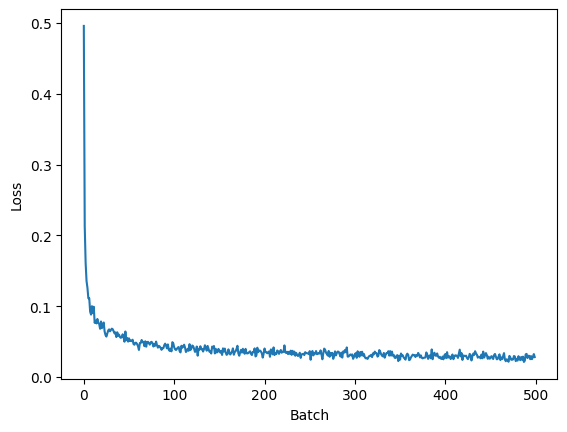

In [59]:
#Plot the history of the loss values over batches
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

# Test

In [60]:
#Load the testing dataset
test_ds, x_test, y_test = load_dataset(dataset, split="test", is_training=False, repeat = False, batch_size=n_batch)
test = iter(test_ds)

In [61]:
#Load a non-repeating copy of the training dataset
train2 = iter(load_dataset(dataset, split="train", is_training=False, repeat = False, batch_size=n_batch)[0])

In [62]:
#define a labmda to compute accuracy we can dispatch over batches
eval_fn = lambda x: model.apply(params_t, key, x)
eval_fn_spk = lambda x: model.apply(params_t, key, x, spiking=True)

In [63]:
predictions = [eval_fn(b['image']) for b in iter(test_ds)]

In [64]:
usage = jnp.stack([np.array(list(map(matrix_usage, r[1]))) for r in predictions])

In [65]:
np.mean(usage, axis=0)

DeviceArray([1., 1.], dtype=float32)

In [69]:
#compute the test set accuracy
preds = jnp.concatenate([r[0] for r in predictions])
test_acc = jnp.mean(accuracy_quadrature(preds, y_test))
print("Test set accuracy is ", test_acc)

Test set accuracy is  0.8422


In [39]:
eval_fn_spk = lambda x: model.apply(params_t, key, x, spiking=True,)
phase = eval_fn_spk(x)

In [57]:
test_acc_spk = np.mean(accuracy_quadrature(phase, y), axis=1)

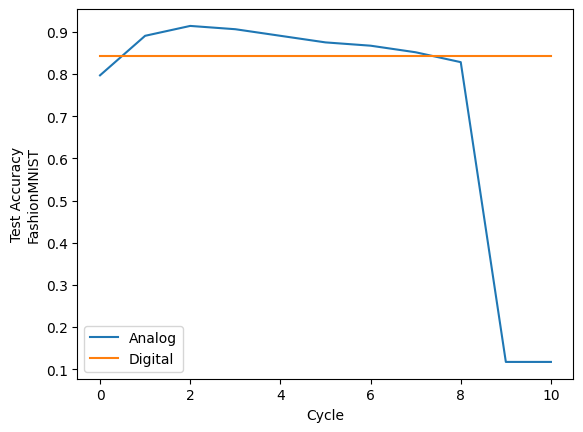

In [62]:
plt.plot(test_acc_spk, label="Analog")
plt.plot(test_acc * np.ones_like(test_acc_spk), label="Digital")
plt.xlabel("Cycle")
plt.ylabel("Test Accuracy\nFashionMNIST")
plt.legend()

In [ ]:
eval_fn_spk = lambda x: model.apply(params_t, key, x, spiking=True,)
phase = eval_fn_spk(x)

In [64]:
phase.shape

(128, 10, 11)

In [74]:
phase_spk = [eval_fn_spk(b['image']) for b in tqdm(iter(test_ds))]

79it [04:21,  3.30s/it]


In [76]:
phase_spk2 = jnp.concatenate(phase_spk, axis=0)

In [77]:
phase_spk2.shape

(10000, 10, 11)

In [81]:
full_test_acc = np.mean(accuracy_quadrature(phase_spk2, y_test), axis=1)

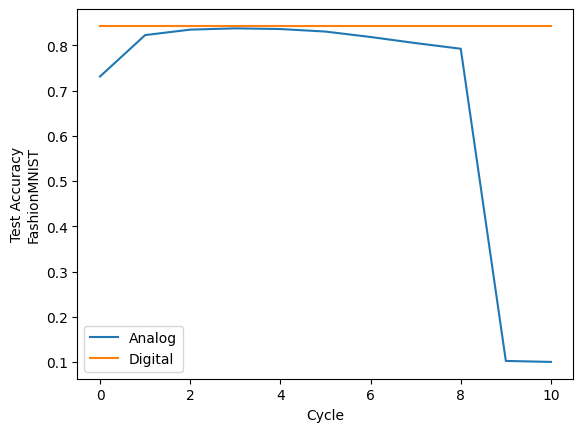

In [83]:
plt.plot(full_test_acc, label="Analog")
plt.plot(test_acc * np.ones_like(test_acc_spk), label="Digital")
plt.xlabel("Cycle")
plt.ylabel("Test Accuracy\nFashionMNIST")
plt.legend()

In [106]:
eval_fn_spk_masked = lambda x, ma: model.apply(params_t, key, x, spiking=True, mask_angle = ma) 

In [110]:
np.mean(accuracy_quadrature(eval_fn_spk_masked(x, 1.0), y), axis=1)

DeviceArray([0.1171875], dtype=float32)

In [109]:
np.mean(accuracy_quadrature(eval_fn_spk_masked(x, 0.00), y), axis=1)

DeviceArray([0.796875 , 0.890625 , 0.9140625, 0.90625  , 0.890625 ,
             0.875    , 0.8671875, 0.8515625, 0.828125 , 0.1171875,
             0.1171875], dtype=float32)

In [111]:
def test_mask_angle(mask_angle: float):
    phases = jnp.concatenate([eval_fn_spk_masked(b['image'], mask_angle) for b in tqdm(iter(test_ds))], axis=0)
    accuracy =  np.mean(accuracy_quadrature(phases, y_test), axis=1)
    return accuracy

In [112]:
angles = np.linspace(0.0, 0.10, 11)

In [ ]:
test_mask_angle(0.10)

In [113]:
masked_accuracies = list(map(test_mask_angle, angles))

79it [04:18,  3.27s/it]
79it [04:20,  3.30s/it]
79it [04:31,  3.44s/it]
79it [04:07,  3.13s/it]
79it [04:07,  3.13s/it]
79it [04:07,  3.13s/it]
79it [04:06,  3.13s/it]
79it [04:01,  3.05s/it]
79it [04:00,  3.05s/it]
79it [04:03,  3.09s/it]
79it [04:03,  3.08s/it]


In [114]:
ama = jnp.stack(masked_accuracies)

In [115]:
ama.shape

(11, 11)

In [116]:
ama.shape

(11, 11)

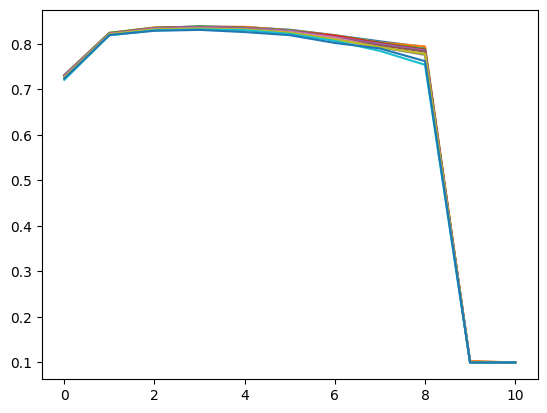

In [117]:
plt.plot(ama.transpose());